## Assignment 03: Object Recognition 



## Training a CNN from scratch on Simpsons and Futurama Characters Image dataset

In this assignment, a CNN model will be built from scratch and trained to recognise pictures of characters from The Simpsons and Futurama series. The model's performace will be compared to the perfomance of other pre-trained CNN models, and thier results will be analysed 

Given that we have to train an image classification model using only very little data, we will first train the new model from scratch on the little data we have without any regularization, to set a baseline for what can be achieved. We will then introduce *data augmentation*, a powerful technique to mitigating overfitting in the model. By leveraging data augmentation, we expect the model to improve in attaining a higher accuracy.

## Downloading the data

As earlier mentioned, the image dataset for this image classification assignment are pictures of characters from The Simpsons and Futurama series downnloaded and others scrapped from the internet. A dataset containing 4676 pictures of Simpsons and Futurama (3,500 Simpsons, 1,176 Futurama). We will use 3,370 pictures for training (2,500 Simpsons, 870 Futurama), and 1306 for testing(1,000 Simpsons, 306 Futurama). For validation set, 20% of the train data will be held back for validation, using the validation_split parameter of the model.

The pictures are medium-resolution color JPEGs and they look like this:

![Simpsons and Futurama_samples](./data/sample_data.jpg)

In [14]:
import os, shutil

In [16]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '.\img_dataset'

# The directory where we will
# store our smaller dataset
base_dir = '.\characters'
os.mkdir(base_dir)

In [18]:
# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [19]:
# Directory with our training simpsons pictures
train_simpsons_dir = os.path.join(train_dir, 'simpsons')
os.mkdir(train_simpsons_dir)

# Directory with our training futurama pictures
train_futurama_dir = os.path.join(train_dir, 'futurama')
os.mkdir(train_futurama_dir)

In [20]:
# Directory with our validation simpsons pictures
validation_simpsons_dir = os.path.join(validation_dir, 'simpsons')
os.mkdir(validation_simpsons_dir)

# Directory with our validation futurama pictures
validation_futurama_dir = os.path.join(validation_dir, 'futurama')
os.mkdir(validation_futurama_dir)

In [21]:
# Directory with our test simpsons pictures
test_simpsons_dir = os.path.join(test_dir, 'simpsons')
os.mkdir(test_simpsons_dir)

# Directory with our test futurama pictures
test_futurama_dir = os.path.join(test_dir, 'futurama')
os.mkdir(test_futurama_dir)

In [8]:
# Copy first 2500 simpsons images to train_simpsons_dir
fnames = ['simpsons_{}.jpg'.format(i) for i in range(2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_simpsons_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 simpsons images to validation_simpsons_dir
fnames = ['simpsons_{}.jpg'.format(i) for i in range(2000, 2500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_simpsons_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 1000 simpsons images to test_simpsons_dir
fnames = ['simpsons_{}.jpg'.format(i) for i in range(2500, 3500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_simpsons_dir, fname)
    shutil.copyfile(src, dst)
    

In [9]:
# Copy first 672 futurama images to train_futurama_dir
fnames = ['futurama_{}.jpg'.format(i) for i in range(672)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_futurama_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 futurama images to validation_futurama_dir
fnames = ['futurama_{}.jpg'.format(i) for i in range(672, 840)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_futurama_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 futurama images to test_futurama_dir
fnames = ['futurama_{}.jpg'.format(i) for i in range(840, 1176)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_futurama_dir, fname)
    shutil.copyfile(src, dst)

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [22]:
print('total training simpsons images:', len(os.listdir(train_simpsons_dir)))
print('total validation simpsons images:', len(os.listdir(validation_simpsons_dir)))
print('total test simpsons images:', len(os.listdir(test_simpsons_dir)))
print('------------------------------------------')
print('total training futurama images:', len(os.listdir(train_futurama_dir)))
print('total validation futurama images:', len(os.listdir(validation_futurama_dir)))
print('total test futurama images:', len(os.listdir(test_futurama_dir)))

total training simpsons images: 2000
total validation simpsons images: 500
total test simpsons images: 1000
------------------------------------------
total training futurama images: 672
total validation futurama images: 168
total test futurama images: 336


## Building our network

The convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers. Since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger. We will have one more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the 
feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 150x150 (a somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the `Flatten` layer. Since we are solving a binary classification problem, we will end the network with a single unit (a `Dense` layer of size 1) and a 
`sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [23]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)      

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will use binary crossentropy as our loss.

In [25]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

## Data preprocessing

Data should be formatted into appropriately pre-processed floating point tensors before being fed into our 
network by the help of Keras utilities:  `keras.preprocessing.image`and`ImageDataGenerator`.

In [26]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=10,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary')

Found 2672 images belonging to 2 classes.
Found 668 images belonging to 2 classes.


Each generator yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). 

In [27]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (10, 150, 150, 3)
labels batch shape: (10,)


In [30]:
# Training the model
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 24s 245ms/step - loss: 0.0503 - acc: 0.9860 - val_loss: 0.0284 - val_acc: 0.9860
Epoch 2/30
100/100 [==============================] - 26s 262ms/step - loss: 0.0274 - acc: 0.9930 - val_loss: 0.0334 - val_acc: 0.9880
Epoch 3/30
100/100 [==============================] - 26s 262ms/step - loss: 0.0310 - acc: 0.9900 - val_loss: 0.0494 - val_acc: 0.9820
Epoch 4/30
100/100 [==============================] - 26s 263ms/step - loss: 0.0363 - acc: 0.9870 - val_loss: 0.0250 - val_acc: 0.9880
Epoch 5/30
100/100 [==============================] - 27s 273ms/step - loss: 0.0275 - acc: 0.9909 - val_loss: 0.0399 - val_acc: 0.9800
Epoch 6/30
100/100 [==============================] - 26s 262ms/step - loss: 0.0241 - acc: 0.9929 - val_loss: 0.0129 - val_acc: 0.9940
Epoch 7/30
100/100 [==============================] - 27s 269ms/step - loss: 0.0332 - acc: 0.9879 - val_loss: 0.0297 - val_acc: 0.9860
Epoch 8/30
100/100 [==============================] - 2

We save the models after training:

In [31]:
model.save('simpsons_and_futurama_1.keras')

Let's plot the loss and accuracy of the model over the training and validation data during training:

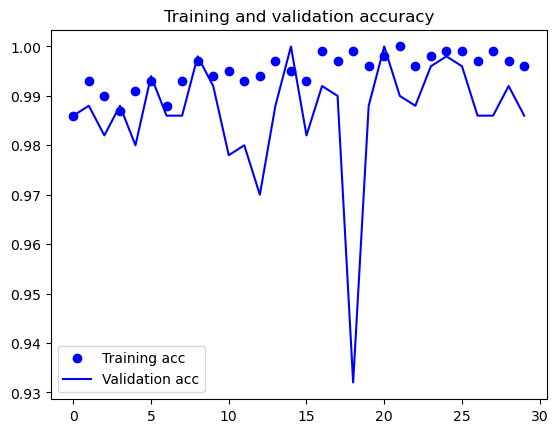

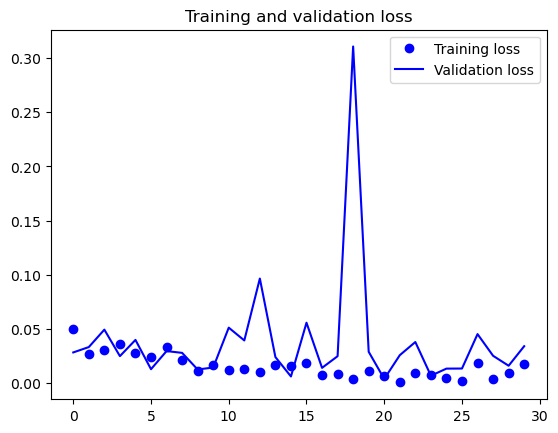

In [32]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our validation accuracy fluctuates between 93-99%. Our validation loss reaches its minimum after only 8 epochs then stalls, while the training loss keeps fluctuating between 0.02-0.30.

To mitigate overfiting we will use *data augmentation*.

## Using data augmentation

In Keras, Data augmentation can be done by configuring a number of random transformations to be performed on the images read by `ImageDataGenerator`

In [28]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Let's take a look at our augmented images:

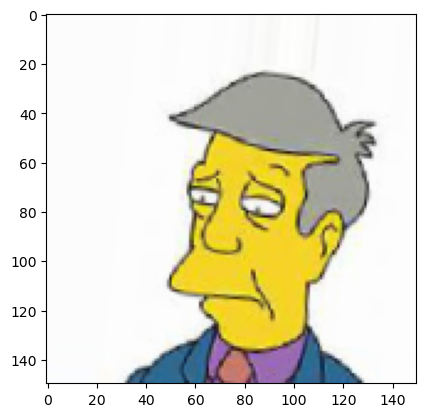

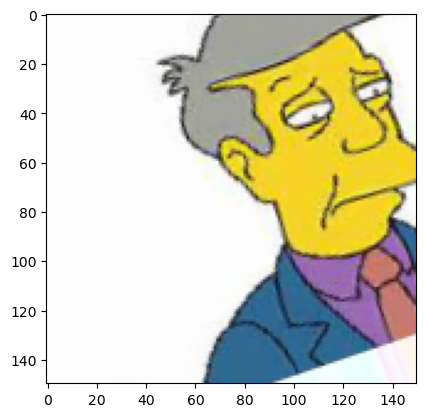

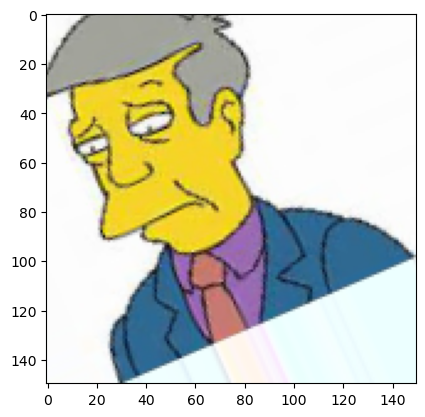

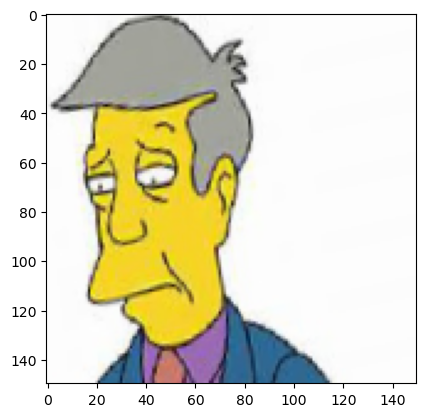

In [43]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_simpsons_dir, fname) for fname in os.listdir(train_simpsons_dir)]

# We pick one image to "augment"
img_path = fnames[7]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight 
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

Let's train our network using data augmentation and dropout:

In [46]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=10,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary')

Found 2672 images belonging to 2 classes.
Found 668 images belonging to 2 classes.


In [47]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 23s 227ms/step - loss: 0.1672 - acc: 0.9380 - val_loss: 0.3741 - val_acc: 0.8680
Epoch 2/100
100/100 [==============================] - 23s 226ms/step - loss: 0.1467 - acc: 0.9470 - val_loss: 0.0952 - val_acc: 0.9600
Epoch 3/100
100/100 [==============================] - 25s 246ms/step - loss: 0.1380 - acc: 0.9470 - val_loss: 0.1801 - val_acc: 0.9180
Epoch 4/100
100/100 [==============================] - 31s 311ms/step - loss: 0.1303 - acc: 0.9560 - val_loss: 0.0346 - val_acc: 0.9840
Epoch 5/100
100/100 [==============================] - 30s 300ms/step - loss: 0.1200 - acc: 0.9630 - val_loss: 0.2577 - val_acc: 0.9020
Epoch 6/100
100/100 [==============================] - 30s 298ms/step - loss: 0.1229 - acc: 0.9600 - val_loss: 0.1716 - val_acc: 0.9360
Epoch 7/100
100/100 [==============================] - 32s 314ms/step - loss: 0.0999 - acc: 0.9620 - val_loss: 0.1696 - val_acc: 0.9400
Epoch 8/100
100/100 [===========================

Let's save our model -- we will be using it in the section on convnet visualization.

In [48]:
model.save('simpsons_and_futurama_2.keras')

Let's plot our results again:

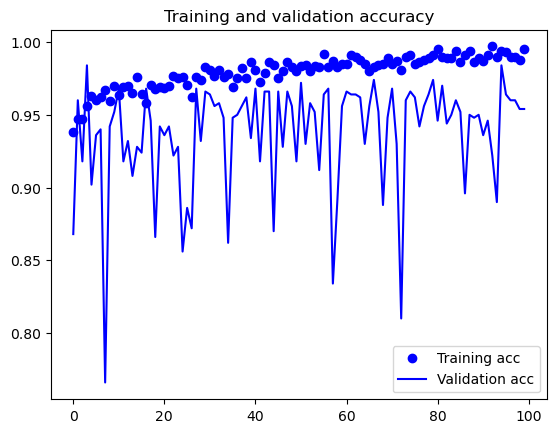

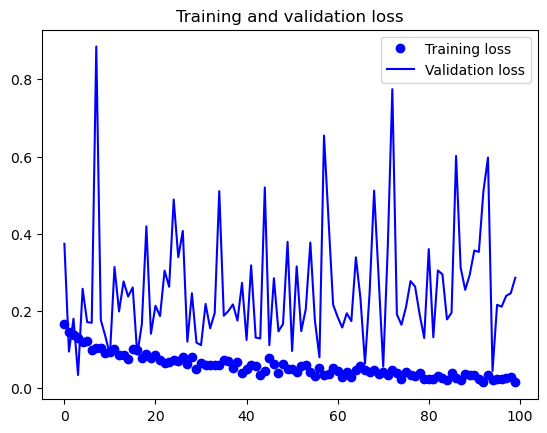

In [49]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, the model is improving. In-spite of the fluctuating validation loss and accuracy we are no longer overfitting: the training curves are rather closely tracking the validation curves. 

To improve our accuracy on this problem, we will have to leverage a pre-trained model.

### Using a pre-trained convnet
We will be using the VGG16 architecture and see how they perform on our dataset.

In [29]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))


We would extending the model  by adding Dense layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. 

In [30]:
from keras import models
from keras import layers

model_2 = models.Sequential()
model_2.add(conv_base)
model_2.add(layers.Flatten())
model_2.add(layers.Dense(256, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

In [31]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 million parameters. Before compiling and training model, we will freeze the convolutional base.

In [32]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model_2.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [33]:
conv_base.trainable = False

In [34]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model_2.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two Dense layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous model:

In [35]:
from keras import optimizers

model_2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

history = model_2.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30
100/100 - 144s - loss: 0.4117 - acc: 0.8075 - val_loss: 0.3317 - val_acc: 0.8400 - 144s/epoch - 1s/step
Epoch 2/30
100/100 - 159s - loss: 0.2725 - acc: 0.9022 - val_loss: 0.2249 - val_acc: 0.9560 - 159s/epoch - 2s/step
Epoch 3/30
100/100 - 159s - loss: 0.1850 - acc: 0.9600 - val_loss: 0.1758 - val_acc: 0.9700 - 159s/epoch - 2s/step
Epoch 4/30
100/100 - 158s - loss: 0.1301 - acc: 0.9819 - val_loss: 0.1256 - val_acc: 0.9780 - 158s/epoch - 2s/step
Epoch 5/30
100/100 - 158s - loss: 0.0992 - acc: 0.9869 - val_loss: 0.0970 - val_acc: 0.9840 - 158s/epoch - 2s/step
Epoch 6/30
100/100 - 157s - loss: 0.0758 - acc: 0.9960 - val_loss: 0.0746 - val_acc: 0.9920 - 157s/epoch - 2s/step
Epoch 7/30
100/100 - 158s - loss: 0.0609 - acc: 1.0000 - val_loss: 0.0625 - val_acc: 0.9900 - 158s/epoch - 2s/step
Epoch 8/30
100/100 - 158s - loss: 0.0469 - acc: 0.9980 - val_loss: 0.0489 - val_acc: 0.9880 - 158s/epoch - 2s/step
Epoch 9/30
100/100 - 158s - loss: 0.0382 - acc: 1.0000 - val_loss: 0.0503 - val_

Let's plot our results again:

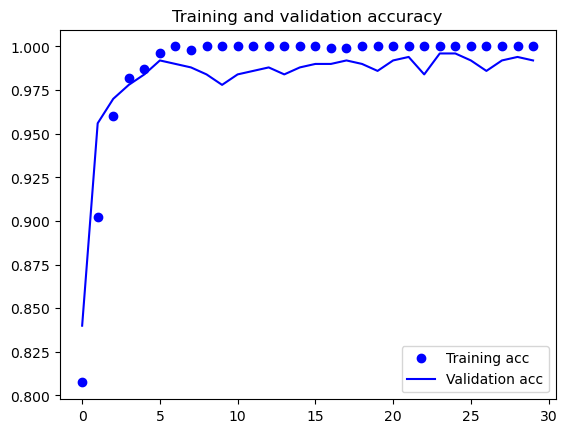

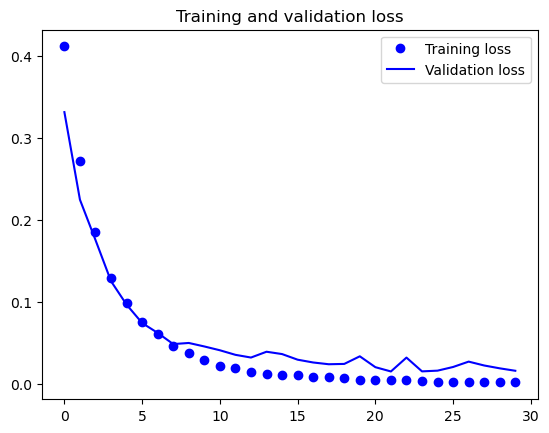

In [37]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As you can see, we reach a validation accuracy of about 96%. This is much better than our small convnet trained from scratch.